In [1]:
!pip install transformers
!pip install transformers[torch]

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('/kaggle/input/combined-data-enghin-csv/combined_data_ENGHIN.csv')

In [3]:
df.dropna(inplace = True)

In [4]:
df['text'].fillna('', inplace=True)

In [5]:
import re
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'[^\w\s]', '', text)
        text = text.lower()
        text = ' '.join(text.split())
        return text
    else:
        return ''

In [6]:
df['text'] = df['text'].apply(lambda x: clean_text(x))

In [7]:
y = df['label'].tolist()
x = df['text'].tolist()

In [8]:
train_size = 0.7  # 70% of the data for training
validation_size = 0.15  # 15% for validation
test_size = 0.15  # 15% for testing

# First, split the data into training and the rest
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=1 - train_size, random_state=42)

# Next, split the remaining data into validation and test sets
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=test_size / (test_size + validation_size), random_state=42)

# The data is now split into X_train, y_train (training), X_val, y_val (validation), and X_test, y_test (test)


In [9]:
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
train_encodings = tokenizer(x_train, truncation=True, padding=True, return_tensors='pt')
val_encodings = tokenizer(x_val, truncation=True, padding=True, return_tensors='pt')
test_encodings = tokenizer(x_test, truncation=True, padding=True, return_tensors='pt')


In [16]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, y_train)
val_dataset = CustomDataset(val_encodings, y_val)
test_dataset = CustomDataset(test_encodings, y_test)

In [17]:
training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    evaluation_strategy='steps',
    save_total_limit=2,
    learning_rate=2e-5,
    logging_dir='./logs',
    logging_steps=100,
    eval_steps=100,
    load_best_model_at_end=True,
)

In [18]:
from transformers import DataCollatorWithPadding
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=DataCollatorWithPadding(tokenizer),  # This handles padding of variable-length sequences.
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)


In [19]:
trainer.train()


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
100,0.328500,0.163415
200,0.171200,0.148135
300,0.166000,0.154326
400,0.147800,0.142170
500,0.088100,0.129230
600,0.104500,0.109262
700,0.102800,0.084428
800,0.081500,0.073857
900,0.082200,0.081759
1000,0.066900,0.092243


TrainOutput(global_step=9684, training_loss=0.041074510569115256, metrics={'train_runtime': 27349.7769, 'train_samples_per_second': 5.665, 'train_steps_per_second': 0.354, 'total_flos': 4.076274336270336e+16, 'train_loss': 0.041074510569115256, 'epoch': 3.0})

In [20]:
model.save_pretrained('my_bertModel')

In [21]:
results = trainer.predict(test_dataset=test_dataset)

In [22]:
results

PredictionOutput(predictions=array([[-5.0863495,  4.9030123],
       [ 4.3758235, -4.382322 ],
       [-4.640655 ,  4.42702  ],
       ...,
       [-4.8283362,  4.6139684],
       [-4.944969 ,  4.766537 ],
       [ 4.0349646, -4.0433173]], dtype=float32), label_ids=array([1, 0, 1, ..., 1, 1, 0]), metrics={'test_loss': 0.04424411430954933, 'test_runtime': 199.5949, 'test_samples_per_second': 55.447, 'test_steps_per_second': 3.467})

In [25]:
import numpy as np
predicted_labels = np.argmax(results.predictions, axis=1)
correct_predictions = (predicted_labels == y_test)
accuracy = np.sum(correct_predictions) / len(y_test)

In [29]:
correct_predictions

array([ True,  True,  True, ...,  True,  True,  True])

In [26]:
accuracy

0.989247311827957

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

In [28]:
accuracy = accuracy_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels)
f1Score = f1_score(y_test, predicted_labels)

In [30]:
print("Accuracy: ", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1Score)

Accuracy:  0.989247311827957
Precision: 0.9915147138472649
Recall: 0.98705966930266
F1 Score: 0.9892821759884717


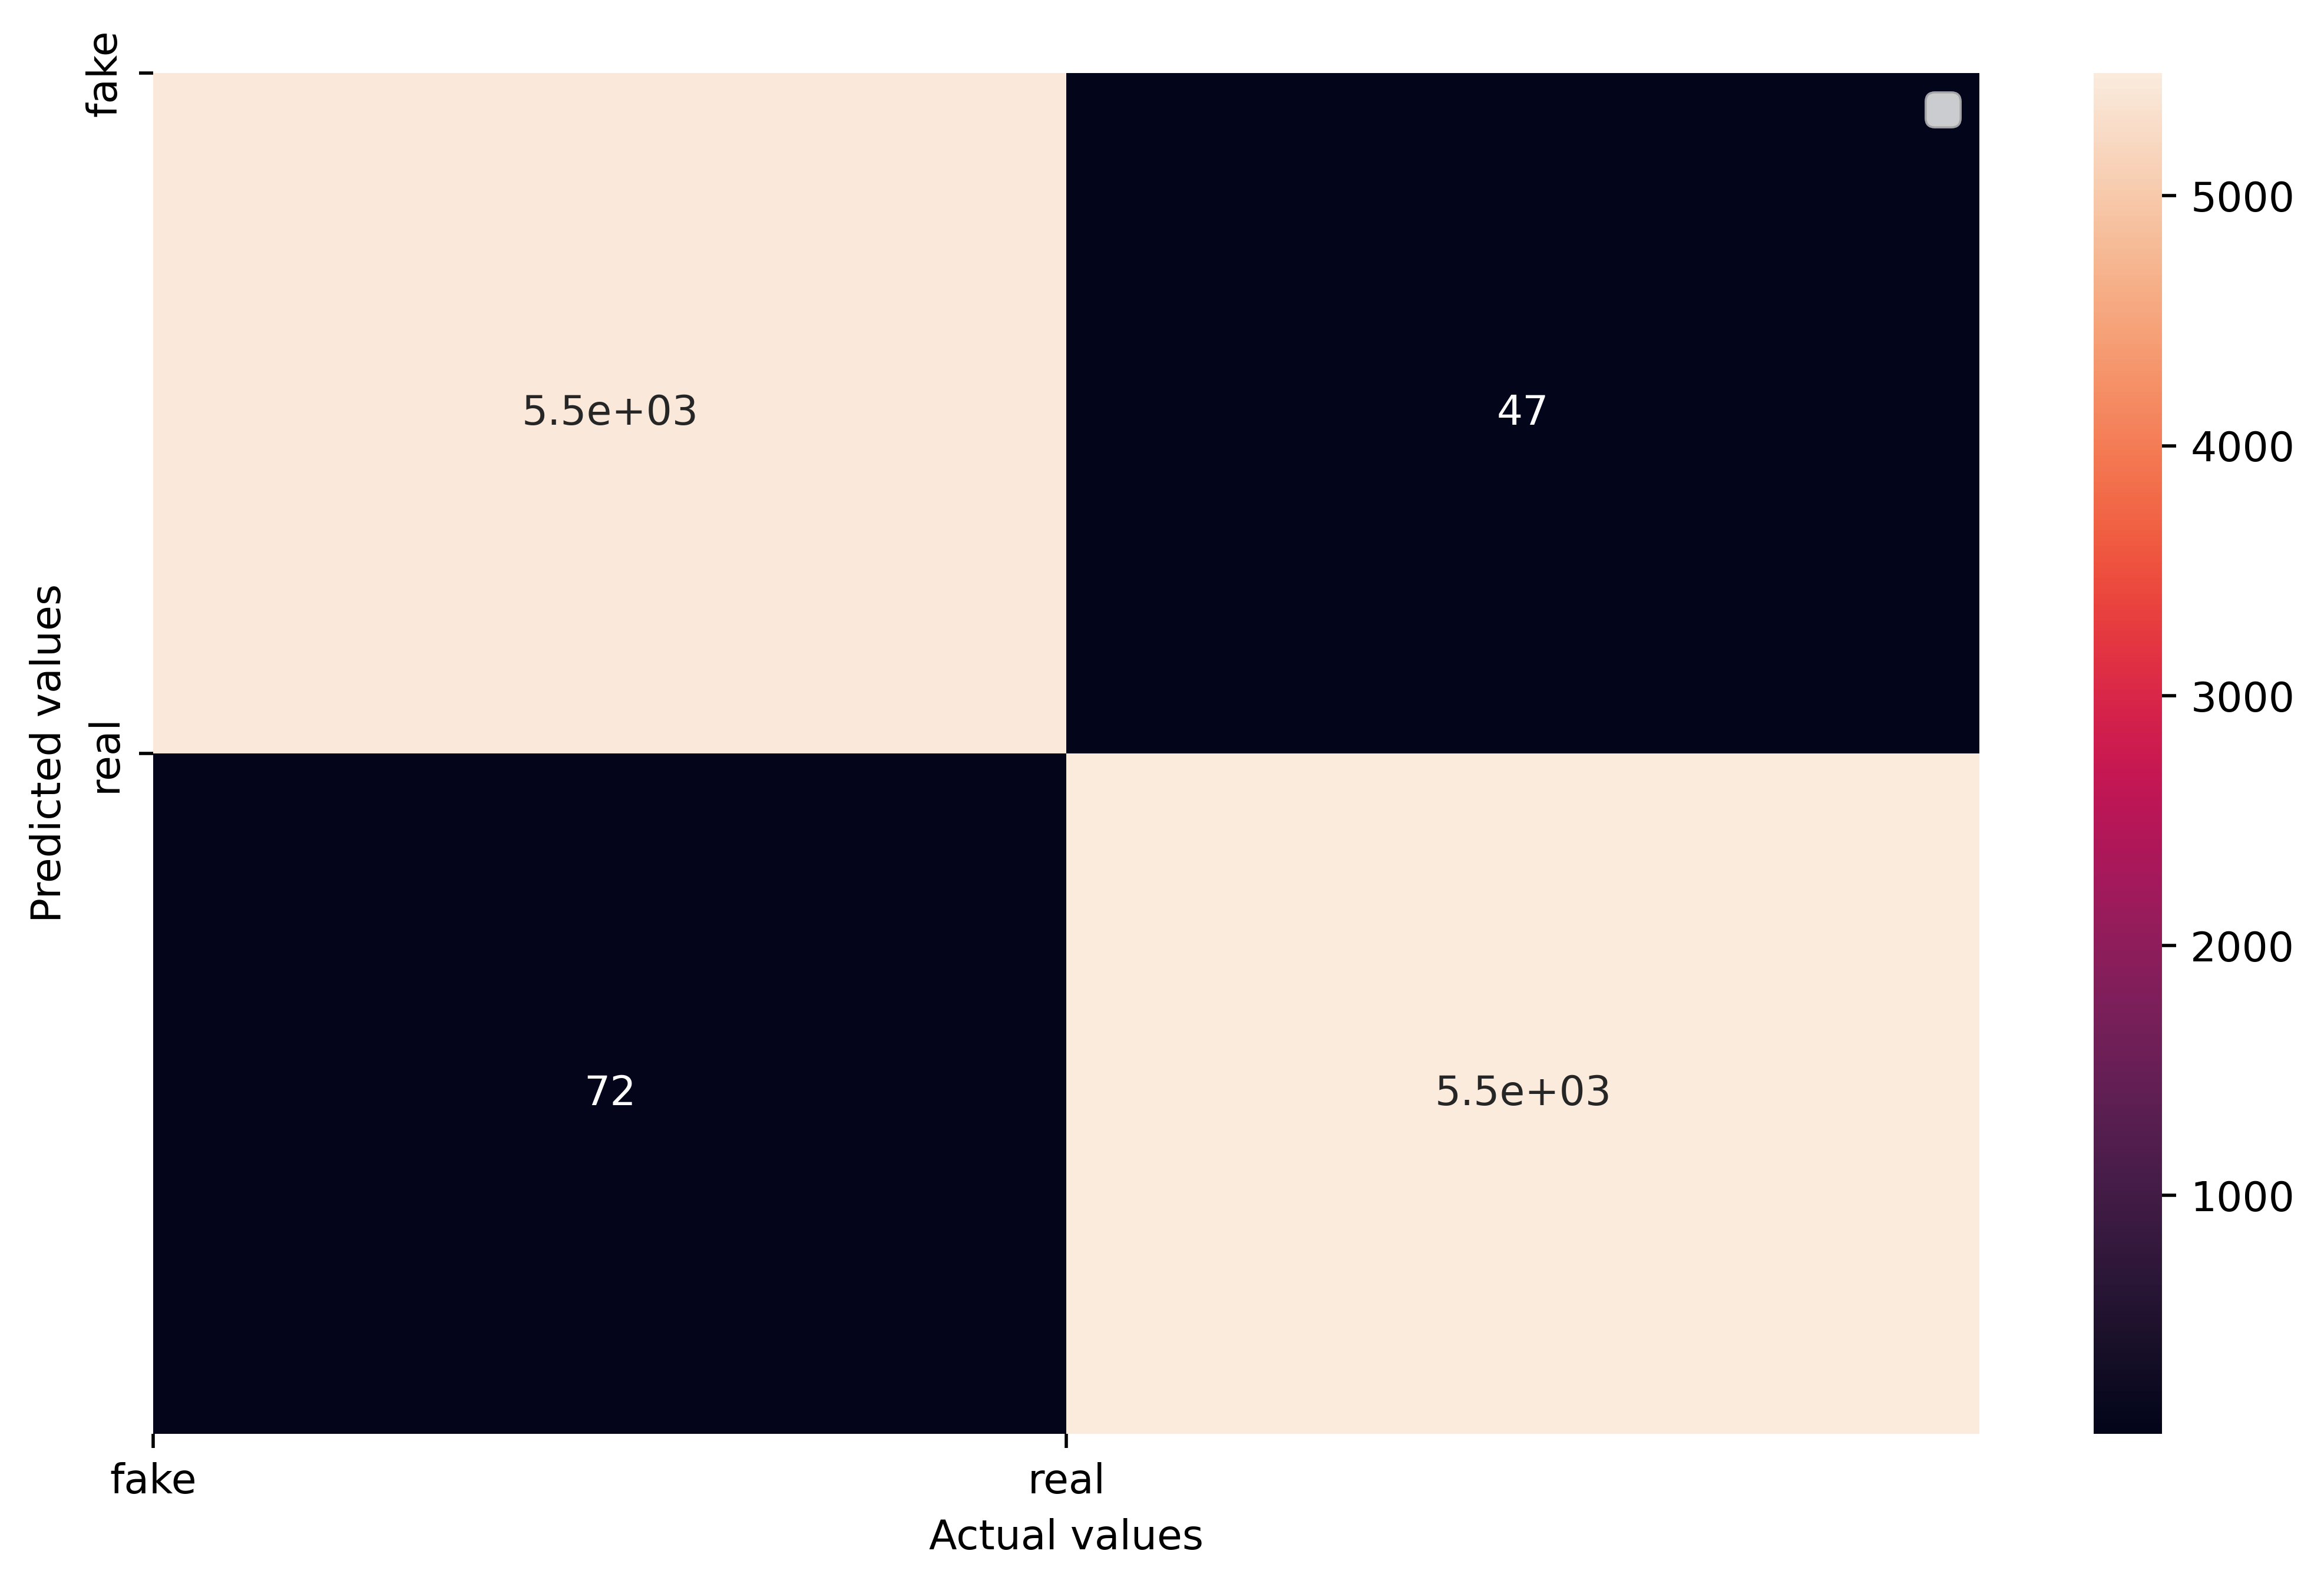

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
cm_rf = confusion_matrix(y_test, predicted_labels)
class_names = ['fake', 'real']
plt.figure(figsize = (10, 6), dpi = 500)
sns.heatmap(cm_rf, annot = True)
plt.xticks([0, 1], class_names)
plt.yticks([0, 1], class_names)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.legend()